In [21]:
#Standard Header used on the projects

#first the major packages used for math and graphing
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler


#Custome graph format style sheet
plt.style.use('Prospectus.mplstyle')

#If being run by a seperate file, use the seperate file's graph format and saving paramaeters
#otherwise set what is needed
if not 'Saving' in locals():
    Saving = True
if not 'Titles' in locals():
    Titles = True
if not 'Ledgends' in locals():
    Ledgends = True
if not 'FFormat' in locals():
    FFormat = '.eps'
if not 'location' in locals():
    #save location.  First one is for running on home PC, second for running on the work laptop.  May need to make a global change
    location = 'E:\\Documents\\Dan\\Code\\FigsAndPlots\\FigsAndPlotsDocument\\Figures\\'
    #location = 'C:\\Users\\dhendrickson\\Documents\\github\\FigsAndPlots\\FigsAndPlotsDocument\\Figures\\'


#Standard cycle for collors and line styles
#default_cycler = (cycler('color', ['0.00', '0.40', '0.60', '0.70']) + cycler(linestyle=['-', '--', ':', '-.']))
#plt.rc('axes', prop_cycle=default_cycler)

In [22]:
# Task Specific includes:

#import scipy.special as sp
import math
import numba as nb
import multiprocessing
import pandas as pd
from joblib import Parallel, delayed
import matplotlib.animation as animation
from IPython import display
import time
from numpy import inf
import EFIT_Class as EFIT

In [23]:
# set Constants:
PoissonRatio = 0.3
YoungModulus = 20 * (10**9)
mu = 80 * (10**9)         #First Lame Parameter
lmbda = 2 * mu * PoissonRatio / (1 - 2 * PoissonRatio)     #second Lame Parameter
rho = 7800       #density

#Calculate speed of longitudinal and transverse waves
cl = np.sqrt((lmbda + 2* mu)/rho)
ct = np.sqrt(mu/rho)

print(cl,ct)

#Choose ferquency to be used for excitment
frequency = 40000

#calculate wave length
omegal = cl / frequency
omegat = ct / frequency

print(omegal,omegat)

# about 1foot (0.3m) of just the web of 175lbs rail 
BeamLength = 0.3
BeamHeight = 0.0762
BeamWidth = 0.0381

5991.446895152781 3202.563076101743
0.14978617237881953 0.08006407690254357


Rail Properties:
https://railroadrails.com/railroad-rail-specification/
Using 175LBS Rail baseline

Steel Propoerties:
https://www.jsg.utexas.edu/tyzhu/files/Some-Useful-Numbers.pdf

relation between properties na dparameters:
https://en.wikipedia.org/wiki/Lam%C3%A9_parameters


In [24]:
#Run for 2 Cycles:
runtime = 6.0 / frequency 


#Set time step and grid step to be 10 steps per frequency and ten steps per wavelength respectively
ts = 1 / frequency / 20    #time step
gs = min(omegal, omegat) / 10    #grid step

Tsteps = int(math.ceil(runtime / ts)) + 1       #total Time STeps

gl = int(math.ceil(BeamLength / gs)) *2        #number of grid points
gh = int(math.ceil(BeamHeight / gs)) *2
gw = int(math.ceil(BeamWidth / gs)) *2

print(gl,gh,gw, ts, gs, gl*gh*gw*3, gl*gh*gw*3)

76 20 10 1.25e-06 0.008006407690254357 45600 45600


In [25]:
#Initialize EFIT Model
Rail = EFIT.EFIT(gl, gh, gw, ts, gs)

#Set Material Properties consitant througout
Rail.Gp[0,:,:,:] = rho  #constant Density
Rail.Gp[1,:,:,:] = lmbda #Constant first Lamee parameter 
Rail.Gp[2,:,:,:] = mu  #constant second Lamee parameter

Rail.Gp[0,:,0,:] = 999999
Rail.Gp[0,:,gh+1,:] = 0.000001
Rail.Gp[0,0,:,:] = 0.000001
Rail.Gp[0,gl+1,:,:] = 0.000001
Rail.Gp[0,:,:,0] = 0.000001
Rail.Gp[0,:,:,gw+1] = 0.000001


num_cores = multiprocessing.cpu_count()

In [26]:
#Run main function for time:
CenterXResults = []
CenterYResults = []
CenterZResults = []

#x = np.linspace(0, BeamLength, gl)
#y = np.linspace(0, BeamHeight, gh)
#X,Y = np.meshgrid(x,y)
#
#plt.ion()
#
#fig = plt.figure()
#ax = plt.axes(xlim=(0, BeamLength), ylim=(0, BeamWidth))  
#plt.xlabel(r'length')
#plt.ylabel(r'height')
#plt.show()

#AllCombos = np.array(np.meshgrid(range(gl),range(gh),range(gw))).T.reshape(-1,3)
#GroupSize = num_cores*3
#Groups = math.ceil(np.shape(AllCombos)[0] / GroupSize)

t=0
TempZ=Rail.VelocityCut(2)
CenterZResults.append((TempZ,t))
np.savetxt(str(t)+'.csv', TempZ, delimiter=",")

for i in range(Tsteps - 1):
    t = (i+1) * ts

    #if i == 2: Rail.ForcingFunctionImpulse(10)
    if i>=2 and i<=20:
        Rail.ForcingFunctionWave(t)
    
    #Update Stresses at next half step:
    for x in range(gl+2):
        for z in range(gw+2):
                for y1 in range(gh+2):
                    y = gh+2-y1-1
                    Rail.UpdateStressesSeries(x,y,z)
    Rail.Gs[np.isnan(Rail.Gs)] = 0
    Rail.Gs[Rail.Gs == inf] = 0
    Rail.Gs[Rail.Gs == -inf] = 0

    #for j in range(Groups):
    #    null = Parallel(n_jobs=num_cores)(delayed(Rail.UpdateStresses)(triple) for triple in AllCombos[j*GroupSize:(j+1)*GroupSize])

    #Update stresses with forcing function
    #if i >= 1 and i <= 4: Rail.ForcingFunctionImpulse(t)
    #if i >= 3 and i <= 33: Rail.ForcingFunctionWave(t)
    #if i == 2: Rail.ForcingFunctionImpulse(10)
    #Rail.ForcingFunctionWave(t)
    
    #update Velocity:
    for x in range(gl+2):
        for y in range(gh+2):
            for z in range(gw+2):
                Rail.UpdateVelocitySeries(x,y,z)
    Rail.Gv[np.isnan(Rail.Gv)] = 0
    Rail.Gv[Rail.Gv == inf] = 0
    Rail.Gv[Rail.Gv == -inf] = 0
    #for j in range(Groups):
    #    null = Parallel(n_jobs=num_cores)(delayed(Rail.UpdateVelocity)(triple) for triple in AllCombos[j*GroupSize:(j+1)*GroupSize])
    
    j = 0
    
    # Store results mid process for latter animating
    if i < 14 or i % 4 == 1:
        print(str(i+1) + ' of ' + str(Tsteps-1) +' time steps. time is: '+ str(t))
        #data = Rail.VelocityCut(0)
        CenterXResults.append((Rail.VelocityCut(0),t))
        CenterYResults.append((Rail.VelocityCut(1),t))
        
        TempZ=Rail.VelocityCut(2)
        CenterZResults.append((TempZ,t))

        np.savetxt(str(i)+'V.csv', TempZ, delimiter=",")

        TempZ=Rail.StressCut(2,1,1)
        np.savetxt(str(i)+'S11.csv', TempZ, delimiter=",")
        TempZ=Rail.StressCut(2,1,0)
        np.savetxt(str(i)+'S10.csv', TempZ, delimiter=",")
        TempZ=Rail.StressCut(2,1,2)
        np.savetxt(str(i)+'S12.csv', TempZ, delimiter=",")
        TempZ=Rail.StressCut(2,0,0)
        np.savetxt(str(i)+'S00.csv', TempZ, delimiter=",")
        TempZ=Rail.StressCut(2,0,2)
        np.savetxt(str(i)+'S02.csv', TempZ, delimiter=",")
        TempZ=Rail.StressCut(2,2,2)
        np.savetxt(str(i)+'S22.csv', TempZ, delimiter=",")

        # animation function
        #z = np.matrix(CenterZResults[j][0][:,:]).T
        #cont = plt.contourf(X, Y, z, levels=25, cmap='RdYlBu')
        #fig.canvas.draw()
        #j+=1

    
    

1 of 120 time steps. time is: 1.25e-06
2 of 120 time steps. time is: 2.5e-06
3 of 120 time steps. time is: 3.7500000000000005e-06
4 of 120 time steps. time is: 5e-06
5 of 120 time steps. time is: 6.25e-06
6 of 120 time steps. time is: 7.500000000000001e-06
7 of 120 time steps. time is: 8.750000000000001e-06
8 of 120 time steps. time is: 1e-05
9 of 120 time steps. time is: 1.125e-05
10 of 120 time steps. time is: 1.25e-05
11 of 120 time steps. time is: 1.375e-05
12 of 120 time steps. time is: 1.5000000000000002e-05
13 of 120 time steps. time is: 1.6250000000000002e-05
14 of 120 time steps. time is: 1.7500000000000002e-05
18 of 120 time steps. time is: 2.25e-05
22 of 120 time steps. time is: 2.75e-05
26 of 120 time steps. time is: 3.2500000000000004e-05
30 of 120 time steps. time is: 3.7500000000000003e-05
34 of 120 time steps. time is: 4.25e-05
38 of 120 time steps. time is: 4.75e-05


e:\Documents\Dan\Code\Prospectus\EFIT\EFIT_Class.py:141: RuntimeWarning: overflow encountered in float_scalars
  Lame1*(self.Gv[0,x,y,z,1]-self.Gv[0,x-1,y,z,1]+self.Gv[2,x,y,z,1]-self.Gv[2,x,y,z-1,1])
e:\Documents\Dan\Code\Prospectus\EFIT\EFIT_Class.py:154: RuntimeWarning: overflow encountered in float_scalars
  Lame1*(self.Gv[0,x,y,z,1]-self.Gv[0,x-1,y,z,1]+self.Gv[1,x,y,z,1]-self.Gv[1,x,y-1,z,1])


42 of 120 time steps. time is: 5.25e-05
46 of 120 time steps. time is: 5.75e-05
50 of 120 time steps. time is: 6.25e-05
54 of 120 time steps. time is: 6.75e-05
58 of 120 time steps. time is: 7.25e-05


e:\Documents\Dan\Code\Prospectus\EFIT\EFIT_Class.py:242: RuntimeWarning: overflow encountered in float_scalars
  (self.Gs[0,2,x,y,z,1] - self.Gs[0,2,x-1,y,z,1] + self.Gs[1,2,x,y,z,1] - self.Gs[1,2,x,y-1,z,1] + self.Gs[2,2,x,y,z+1,1] -self.Gs[2,2,x,y,z,1])
e:\Documents\Dan\Code\Prospectus\EFIT\EFIT_Class.py:224: RuntimeWarning: overflow encountered in float_scalars
  (self.Gs[0,0,x+1,y,z,1] - self.Gs[0,0,x,y,z,1] + self.Gs[0,1,x,y,z,1] - self.Gs[0,1,x,y-1,z,1] + self.Gs[0,2,x,y,z,1] -self.Gs[0,2,x,y,z-1,1])
e:\Documents\Dan\Code\Prospectus\EFIT\EFIT_Class.py:233: RuntimeWarning: overflow encountered in float_scalars
  (self.Gs[0,1,x,y,z,1] - self.Gs[0,1,x-1,y,z,1] + self.Gs[1,1,x,y+1,z,1] - self.Gs[1,1,x,y,z,1] + self.Gs[1,2,x,y,z,1] -self.Gs[1,2,x,y,z-1,1])


62 of 120 time steps. time is: 7.75e-05
66 of 120 time steps. time is: 8.250000000000001e-05


e:\Documents\Dan\Code\Prospectus\EFIT\EFIT_Class.py:287: RuntimeWarning: overflow encountered in add
  self.Gs[:,:,x,y,z,1] += delS[:,:] * self.__ts


70 of 120 time steps. time is: 8.750000000000001e-05
74 of 120 time steps. time is: 9.250000000000001e-05
78 of 120 time steps. time is: 9.750000000000001e-05
82 of 120 time steps. time is: 0.00010250000000000001
86 of 120 time steps. time is: 0.00010750000000000001
90 of 120 time steps. time is: 0.00011250000000000001
94 of 120 time steps. time is: 0.00011750000000000001
98 of 120 time steps. time is: 0.00012250000000000002
102 of 120 time steps. time is: 0.0001275
106 of 120 time steps. time is: 0.00013250000000000002
110 of 120 time steps. time is: 0.0001375
114 of 120 time steps. time is: 0.00014250000000000002
118 of 120 time steps. time is: 0.0001475


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


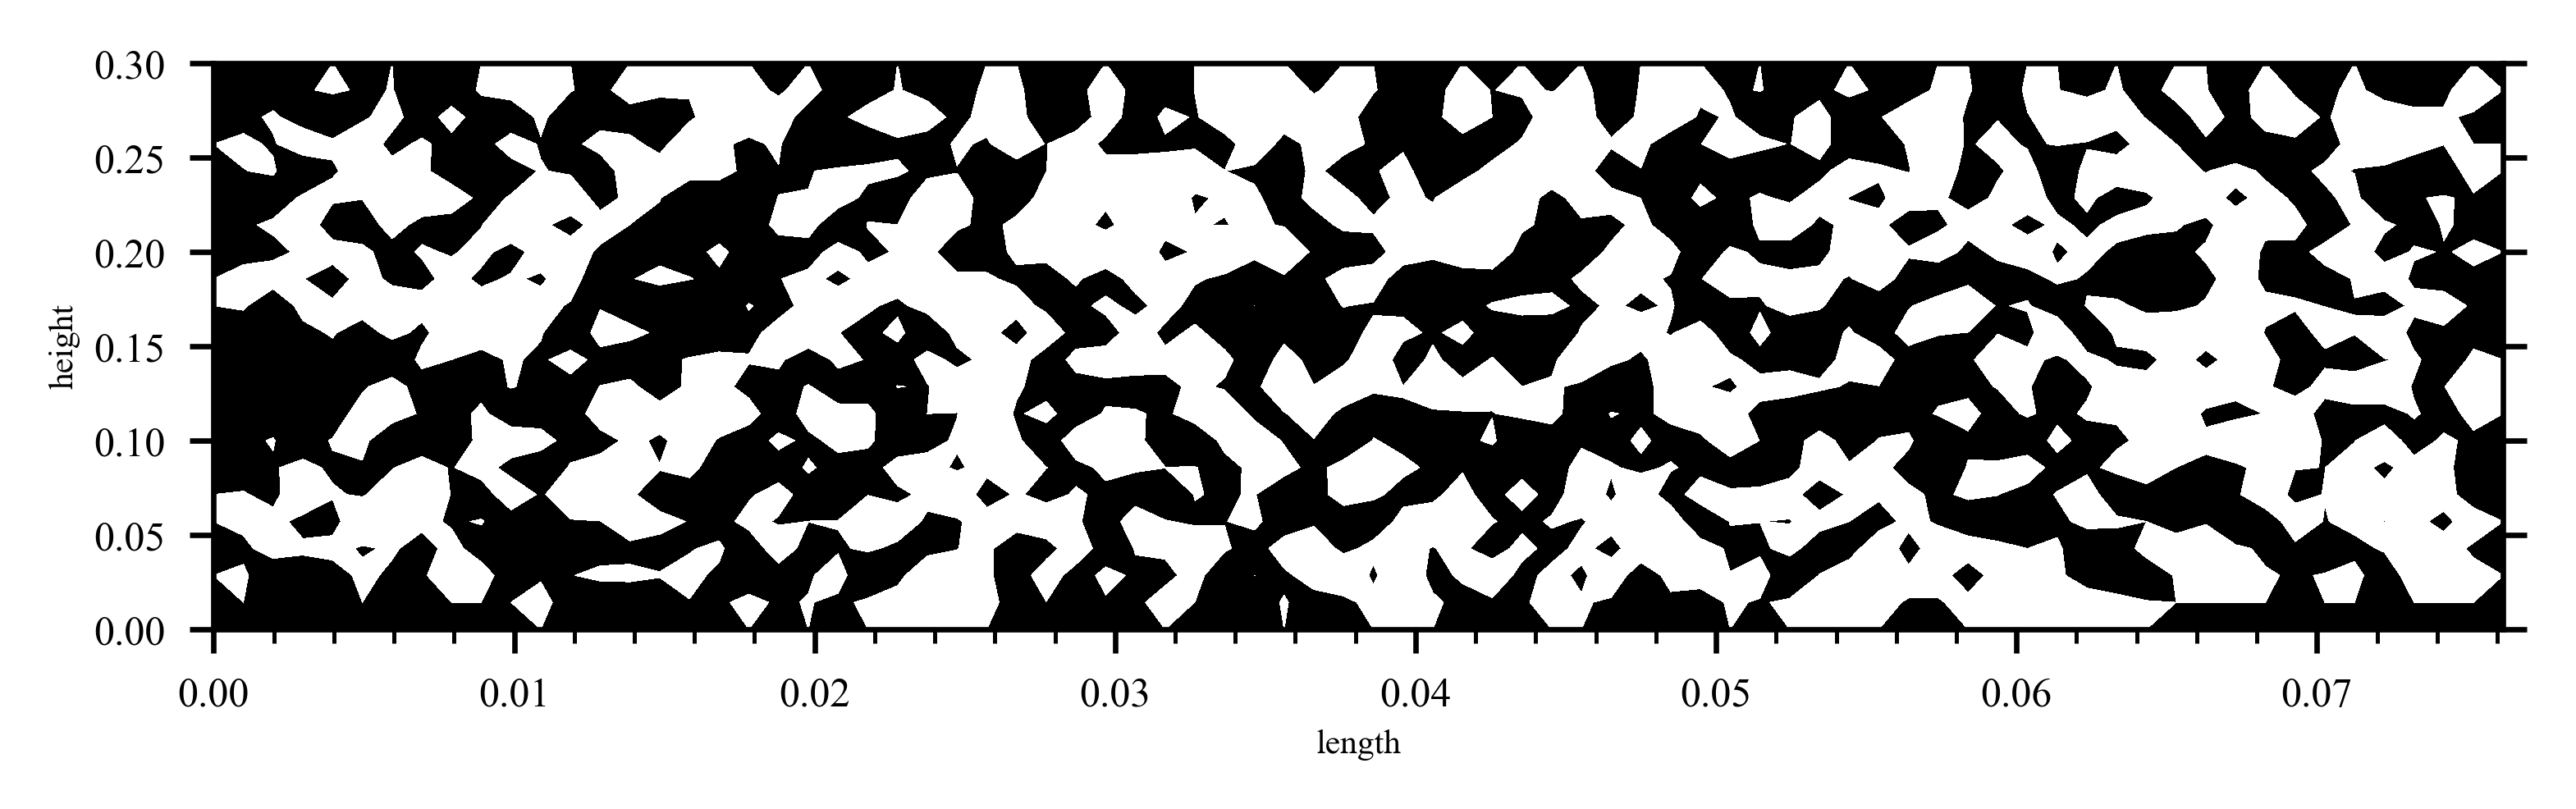

In [27]:
y = np.linspace(0, BeamLength, np.shape(CenterZResults[0][0])[1])
x = np.linspace(0, BeamHeight, np.shape(CenterZResults[0][0])[0])
x,y = np.meshgrid(x,y)

fig = plt.figure(figsize=(6.0,BeamHeight/BeamLength*6.0))
ax = plt.axes(xlim=(0, BeamHeight), ylim=(0, BeamLength))  
plt.ylabel(r'height')
plt.xlabel(r'length')

# animation function
def animate(i): 
    z = np.matrix(CenterZResults[i][0][:,:]).T
    cont = plt.contourf(x, y, z, levels=5, cmap='gray',vmin=-100, vmax=100)
    time.sleep(1)
    return cont  

anim = animation.FuncAnimation(fig, animate, frames=np.shape(CenterZResults)[0])

anim.save('animationZ.mp4')

x = np.linspace(0, BeamLength, np.shape(CenterYResults[0][0])[1])
y = np.linspace(0, BeamWidth, np.shape(CenterYResults[0][0])[0])
x,y = np.meshgrid(x,y)

fig = plt.figure(figsize=(BeamWidth/BeamLength*6.0,6.0))
ax = plt.axes(xlim=(0, BeamLength), ylim=(0, BeamWidth))  
plt.xlabel(r'length')
plt.ylabel(r'width')

# animation function
def animate(i): 
    z = np.matrix(CenterYResults[i][0][:,:])
    cont = plt.contourf(x, y, z, levels=25, cmap='gray')
    time.sleep(1)
    return cont  

anim = animation.FuncAnimation(fig, animate, frames=np.shape(CenterYResults)[0])

anim.save('animationY.mp4')

x = np.linspace(0, BeamWidth, np.shape(CenterXResults[0][0])[1])
y = np.linspace(0, BeamHeight, np.shape(CenterXResults[0][0])[0])
x,y = np.meshgrid(x,y)

fig = plt.figure(figsize=(BeamWidth/BeamHeight*6.0,6.0))

ax = plt.axes(xlim=(0, BeamWidth), ylim=(0, BeamHeight))  
plt.xlabel(r'height')
plt.ylabel(r'width')

# animation function
def animate(i): 
    z = np.matrix(CenterXResults[i][0][:,:])
    cont = plt.contourf(x, y, z, levels=25, cmap='gray')
    time.sleep(1)
    return cont  

anim = animation.FuncAnimation(fig, animate, frames=np.shape(CenterXResults)[0])

anim.save('animationX.mp4')